In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pycaret.classification import *
from sklearn.metrics import log_loss, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
random_state = 42
folds = 2
features = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']
target = 'shot_made_flag'
test_size = 0.2

In [3]:
def plot_confusion_matrix(y_true, y_pred):
    # Define as classes e a matriz de confusão
    classes = ['Arremessos Perdidos', 'Arremessos Convertidos']
    cm = confusion_matrix(y_true, y_pred)

    # Plota a matriz de confusão usando matplotlib
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Configura os rótulos dos eixos e o título
    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
        xlabel='Predição', ylabel='Real',
        title='Matriz de Confusão')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Adiciona os valores aos quadrados
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

## Normalização

In [5]:
# carregar o conjunto de dados
raw_data = pd.read_csv('../Data/01_raw/kobe_dataset.csv', delimiter=',')

# normaliza os dados
raw_data.dropna(inplace=True)

## Treinamento do Modelo com 2PT Field Goal

In [6]:
# filtra os dados pelo critério de arremessos de 2 pts
two_points_df = raw_data[raw_data['shot_type'] == '2PT Field Goal']

two_points_df = two_points_df[[
    'lat',
    'lon',
    'minutes_remaining',
    'period',
    'playoffs',
    'shot_distance',
    'shot_made_flag'
]]

In [7]:
# separar dados de treino e teste
train, test = train_test_split(two_points_df, stratify=two_points_df[target], test_size=test_size, random_state=random_state, shuffle=True)

train_X = train[features]
train_y = train[target]
test_X = test[features]
test_y = test[target]

# X = new_data.drop('shot_made_flag', axis = 1)
# y = new_data.drop(columns=X.columns)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True, stratify=y)

In [ ]:
two_points_df[target].value_counts()

In [8]:
train_y = pd.DataFrame(train_y)
test_y = pd.DataFrame(test_y)

### Regressão Logística

In [ ]:
lr_xp = ClassificationExperiment()
lr_xp.setup(data=train_X, target=train_y.squeeze(), train_size=(1 - test_size), session_id=random_state, fold_strategy = 'stratifiedkfold')

In [ ]:
lr_xp.add_metric('logloss', 'Log Loss', log_loss, greater_is_better = False)
lr_xp.add_metric('F1_score', 'F1 score', f1_score)

In [ ]:
best_lr_model = lr_xp.create_model('lr')
lr_tuned_model = lr_xp.tune_model(best_lr_model)

In [ ]:
lr_train_predictions = lr_xp.predict_model(lr_tuned_model, data=train_X)

In [ ]:
lr_train_log_loss_score = log_loss(train_y, lr_train_predictions['prediction_score'])
lr_train_f1_score = f1_score(train_y, lr_train_predictions['prediction_label'])

In [ ]:
print('Logistic Regreeesion Train log_loss_score: {}\nLogistic Regreeesion Train f1_score: {}'.format(lr_train_log_loss_score, lr_train_f1_score))

### Classificação

In [9]:
# inicializar ambiente pyCaret
classification_xp = ClassificationExperiment()
classification_xp.setup(data=train_X, target=train_y.squeeze(), train_size=(1 - test_size), session_id=random_state, fold_strategy = 'stratifiedkfold')

,Description,Value
0,Session id,42
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(16228, 7)"
4,Transformed data shape,"(16228, 7)"
5,Transformed train set shape,"(12982, 7)"
6,Transformed test set shape,"(3246, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [10]:
classification_xp.add_metric('logloss', 'Log Loss', log_loss, greater_is_better = False)
classification_xp.add_metric('F1_score', 'F1 score', f1_score)

best_classification_model = classification_xp.compare_models(verbose=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,F1 score,TT (Sec)
ada,Ada Boost Classifier,0.5892,0.5999,0.3800,0.6133,0.4688,0.1630,0.1757,6.5491,0.4688,0.8420
gbc,Gradient Boosting Classifier,0.5890,0.5985,0.3921,0.6079,0.4766,0.1634,0.1742,6.5528,0.4766,0.8340
lda,Linear Discriminant Analysis,0.5779,0.5990,0.4906,0.5671,0.5260,0.1491,0.1504,6.7296,0.5260,0.7990
ridge,Ridge Classifier,0.5772,0.0000,0.4893,0.5664,0.5249,0.1476,0.1490,6.7407,0.5249,0.8020
lr,Logistic Regression,0.5764,0.5987,0.4856,0.5661,0.5226,0.1459,0.1474,6.7530,0.5226,1.3100
lightgbm,Light Gradient Boosting Machine,0.5757,0.5923,0.4707,0.5673,0.5143,0.1434,0.1455,6.7640,0.5143,0.8910
qda,Quadratic Discriminant Analysis,0.5746,0.6006,0.5315,0.5573,0.5439,0.1458,0.1461,6.7812,0.5439,0.8320
nb,Naive Bayes,0.5735,0.5953,0.5038,0.5593,0.5300,0.1415,0.1423,6.7996,0.5300,0.7950
rf,Random Forest Classifier,0.5615,0.5751,0.5382,0.5411,0.5395,0.1211,0.1211,6.9900,0.5395,1.0300
et,Extra Trees Classifier,0.5547,0.5664,0.5454,0.5327,0.5389,0.1085,0.1085,7.0993,0.5389,1.1000


In [11]:
classification_best_tuned_model = classification_xp.tune_model(best_classification_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss,F1 score
Fold,,,,,,,,,
0,0.5966,0.6195,0.3645,0.6348,0.4631,0.1763,0.1938,6.4310,0.4631
1,0.5858,0.5958,0.3629,0.6114,0.4555,0.1550,0.1688,6.6028,0.4555
2,0.6063,0.6185,0.3926,0.6429,0.4875,0.1971,0.2130,6.2762,0.4875
3,0.5809,0.5929,0.3457,0.6062,0.4403,0.1437,0.1583,6.6816,0.4403
4,0.6055,0.6133,0.3764,0.6490,0.4765,0.1945,0.2131,6.2885,0.4765
5,0.5686,0.5843,0.3613,0.5773,0.4444,0.1213,0.1303,6.8781,0.4444
6,0.5824,0.5782,0.3468,0.6108,0.4424,0.1474,0.1626,6.6570,0.4424
7,0.6094,0.6272,0.3742,0.6610,0.4779,0.2024,0.2234,6.2271,0.4779
8,0.5878,0.5975,0.3597,0.6177,0.4546,0.1590,0.1741,6.5710,0.4546


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [12]:
classification_best_tuned_model.get_params

<bound method BaseEstimator.get_params of AdaBoostClassifier(algorithm='SAMME.R', base_estimator='deprecated',
                   estimator=None, learning_rate=0.15, n_estimators=110,
                   random_state=42)>

In [13]:
classification_train_predictions = classification_xp.predict_model(classification_best_tuned_model, data=train_X)

In [14]:
classification_train_log_loss_score = log_loss(train_y, classification_train_predictions['prediction_score'])
classification_train_f1_score = f1_score(train_y, classification_train_predictions['prediction_label'])

In [15]:
print('Classification Train log_loss_score: {}\nClassification Train f1_score: {}'.format(classification_train_log_loss_score, classification_train_f1_score))

Classification Train log_loss_score: 0.6934957461541119
Classification Train f1_score: 0.46739393939393936


In [16]:
classification_test_predictions = classification_xp.predict_model(classification_best_tuned_model, data=test_X)

In [17]:
classification_test_log_loss_score = log_loss(test_y, classification_test_predictions['prediction_score'])
classification_test_f1_score = f1_score(test_y, classification_test_predictions['prediction_label'])

### Sumário

In [ ]:
print('Métricas Regressão Linear')
print('---------------------------------------------------------------')
print('Logistic Regreeesion Train - log_loss_score: {}\nLogistic Regression Train -  f1_score: {}'.format(lr_train_log_loss_score, lr_train_f1_score))
# print('Logistic Regreeesion Test - log_loss_score: {}\nLogistic Regression Train f1_score: {}'.format(lr_test_log_loss_score, lr_test_f1_score))
print('')
print('Métricas Classificador')
print('---------------------------------------------------------------')
print('Classification Train - log_loss_score: {}\nClassification Train - f1_score: {}'.format(classification_train_log_loss_score, classification_train_f1_score))
print('Classification Test - log_loss_score: {}\nClassification Test - f1_score: {}'.format(classification_test_log_loss_score, classification_test_f1_score))
print('')
print('Predição com dados de treino - Classificador')
print('---------------------------------------------------------------')
print('Total de Registros: {}\nTotal de erros: {}\nTotal de acertos: {}'.format(
    train_X.shape[0],
    classification_train_predictions['prediction_label'].value_counts()[0],
    classification_train_predictions['prediction_label'].value_counts()[1],
))
print('')
print('Predição com dados de teste - Classificador')
print('---------------------------------------------------------------')
print('Total de Registros: {}\nTotal de erros: {}\nTotal de acertos: {}'.format(
    test_X.shape[0],
    classification_test_predictions['prediction_label'].value_counts()[0],
    classification_test_predictions['prediction_label'].value_counts()[1],
))

## Predição dos Arremessos com 3PT Field Goal

In [19]:
three_points_df = raw_data[raw_data['shot_type'] == '3PT Field Goal']

In [20]:
three_samples_labels = three_points_df['shot_made_flag']
three_samples_df = three_points_df.drop('shot_made_flag', axis=1)

### Classification Prediction

In [21]:
classification_three_points_predictions = classification_xp.predict_model(classification_best_tuned_model, data=three_samples_df)

In [22]:
classification_three_points_predictions_df = classification_three_points_predictions
classification_three_points_predictions_df[target] = three_points_df[target]
classification_three_points_predictions_df[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag', 'prediction_label', 'prediction_score']]

,lat,lon,minutes_remaining,period,playoffs,shot_distance,shot_made_flag,prediction_label,prediction_score
10,33.806301,-118.363800,1,3,0,25,0.0,0,0.5084
17,33.818298,-118.386803,8,2,0,25,1.0,0,0.5084
27,33.858299,-118.452797,0,3,0,26,0.0,0,0.5060
39,33.772301,-118.296799,0,2,0,27,1.0,0,0.5069
55,33.850300,-118.424797,2,1,0,24,0.0,0,0.5051
...,...,...,...,...,...,...,...,...,...
30675,33.828300,-118.403801,2,1,1,25,0.0,0,0.5078
30681,33.783298,-118.287804,0,2,1,26,1.0,0,0.5069
30685,33.794300,-118.188797,7,3,1,26,0.0,0,0.5061
30689,33.365299,-118.281799,0,3,1,67,0.0,0,0.5069


In [23]:
classification_three_points_predictions_log_loss_score = log_loss(three_points_df['shot_made_flag'], classification_three_points_predictions['prediction_score'])
classification_three_points_predictions_f1_score = f1_score(three_points_df['shot_made_flag'], classification_three_points_predictions['prediction_label'])

In [24]:
print('Three Points Predictions log_loss_score: {}\nThree Points Predictions f1_score: {}'.format(classification_three_points_predictions_log_loss_score, classification_three_points_predictions_f1_score))

Three Points Predictions log_loss_score: 0.7024367545108244
Three Points Predictions f1_score: 0.08789062499999999


### Logistic Regression Prediction

In [ ]:
lr_three_points_predictions = lr_xp.predict_model(lr_tuned_model, data=three_samples_df)

In [ ]:
lr_three_points_predictions_df = lr_three_points_predictions
lr_three_points_predictions_df[target] = three_points_df[target]
lr_three_points_predictions_df[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag', 'prediction_label', 'prediction_score']]

In [ ]:
lr_three_points_predictions_log_loss_score = log_loss(three_points_df['shot_made_flag'], lr_three_points_predictions['prediction_score'])
lr_three_points_predictions_f1_score = f1_score(three_points_df['shot_made_flag'], lr_three_points_predictions['prediction_label'])

In [ ]:
print('Three Points Predictions log_loss_score: {}\nThree Points Predictions f1_score: {}'.format(lr_three_points_predictions_log_loss_score, lr_three_points_predictions_f1_score))

### Sumário

In [ ]:
classification_best_tuned_model.get_params

In [25]:
print('--- Classification Test Data Prediction ---')
print('-------------------------------------------')
print('Total de arremessos: {}\nArremessos perdidos: {}\nArremessos convertidos: {}'.format(
    three_samples_df.shape[0],
    classification_three_points_predictions['prediction_label'].value_counts()[0],
    classification_three_points_predictions['prediction_label'].value_counts()[1],
))
print('-------------------------------------------')

--- Classification Test Data Prediction ---
-------------------------------------------
Total de arremessos: 5412
Arremessos perdidos: 5146
Arremessos convertidos: 266
-------------------------------------------


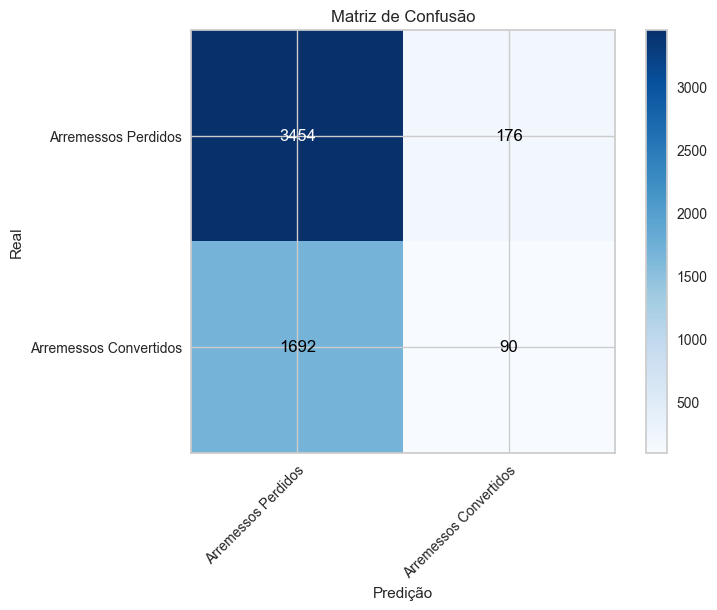

In [26]:
plot_confusion_matrix(three_samples_labels, classification_three_points_predictions['prediction_label'])

In [ ]:
lr_tuned_model.get_params

In [ ]:
print('--- Logistic Regression Test Data Prediction ---')
print('-------------------------------------------')
print('Total de arremessos: {}\nArremessos perdidos: {}\nArremessos convertidos: {}'.format(
    three_samples_df.shape[0],
    lr_three_points_predictions['prediction_label'].value_counts()[0],
    lr_three_points_predictions['prediction_label'].value_counts()[1],
))
print('-------------------------------------------')

In [ ]:
plot_confusion_matrix(three_samples_labels, lr_three_points_predictions['prediction_label'])